In [217]:
import numpy as np 
from math import pi
import matplotlib.pyplot as plt 
from scipy import special

In [218]:
def generate_data(N_train = 2 ** 12, N_test = 2 ** 14): 
    
    def f(x):
        a = 1 / 100
        si, ci = special.sici(x / a)
        return si * np.exp(-x ** 2 / 2)

    x_train = np.random.normal(0, 1, N_train)
    x_train = np.reshape(x_train, (N_train, 1))
    y_train = f(x_train)
    
    x_validation = np.random.normal(0, 1, N_train)
    x_validation = np.reshape(x_validation, (N_train, 1))
    y_validation = f(x_validation)
    
    x_test = np.linspace(-25 * pi, 25 * pi, N_test).reshape(N_test, 1)
    x_test = np.reshape(x_test, (N_test, 1))
    y_test = f(x_test)
    
    plt.plot(x_test, y_test)
    plt.title('y_test')
    plt.show()
    
    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [219]:
def fun(x_train, y_train, w0, px):

    # This function computes the quantity that needs to be minimized when finding w0 for Method 2
    d = x_train.shape[1]
    p_tot = np.mean((y_train - np.mean(y_train)) ** 2)
    f = (y_train - np.mean(y_train))
    fp = f / np.sqrt(px)

    if d == 1:
        diff = x_train - x_train.T
        snc = np.sinc(w0 * diff / np.pi)
    else:
        snc = np.ones((len(x_train), len(x_train)))
        for i in np.arange(0, d):
            diff = x_train[:, i].reshape(len(x_train), 1) - x_train[:, i].reshape(len(x_train), 1).T
            snc *= np.sinc(w0 * diff / np.pi)
    
    return 1 / len(x_train) ** 2 * fp.T @ (snc @ fp) * (w0 / np.pi) ** d / p_tot - 1 / 2


In [220]:
def Method_2_w0(x_train, y_train, guess1, guess2, px):
    # This function finds the cutoff frequency using the secant method, if the ouput dimension is >1, the SB is computed
    # on the average output.

    y_train2 = y_train.mean(axis=1).reshape(len(y_train), 1)
    w0 = np.array([guess1, guess2])
    fun_vals = np.array([fun(x_train, y_train2, w0[0], px), fun(x_train, y_train2, w0[1], px)])

    while np.abs(fun_vals[-1]) > 1e-4:
        w0_temp = w0[-1] - fun_vals[-1] * (w0[-1] - w0[-2]) / (fun_vals[-1] - fun_vals[-2])
        w0 = np.append(w0, w0_temp)
        fun_vals = np.append(fun_vals, fun(x_train, y_train2, w0_temp, px))

    w0 = w0[-1]
    return w0

In [221]:
def Method_2(w0, x, y, prediction, px, snc):
    # Given the cutoff frequency, validation data (x,y), network prediction, density px, and sinc-matrix snc,
    # this function computes the spectral bias with Method 2.

    N, d = x.shape
    var = np.mean((y - np.mean(y)) ** 2)

    r = (y - prediction - np.mean(y - prediction))
    rp = r / np.sqrt(px)
    E_low = 1 / N ** 2 * rp.T @ (snc @ rp) * (w0 / np.pi) ** d / var
    E_high = np.mean(r ** 2) / var - E_low
    SB = (E_high - E_low) / (E_high + E_low)

    return E_low, E_high, SB

In [222]:
def FVU_compute(y, pred): 
    r = y - pred 
    var_r = np.var(r)
    var_f = np.var(y)
    FVU = var_r/var_f 
    return FVU 

In [223]:
# training the function with NN  

import tensorflow as tf 
from tensorflow import keras 

In [224]:
# define the keras model 
K = 64
input_layer = keras.Input(shape = (1, ))
hidden_layer_1 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
hidden_layer_2 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
hidden_layer_3 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
hidden_layer_4 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
hidden_layer_5 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
output_layer = keras.layers.Dense(units = 1, 
                                    use_bias = False)
model = keras.Sequential([input_layer, 
                          hidden_layer_1,
                          hidden_layer_2, 
                          hidden_layer_3, 
                          hidden_layer_4, 
                          hidden_layer_5, 
                          output_layer])

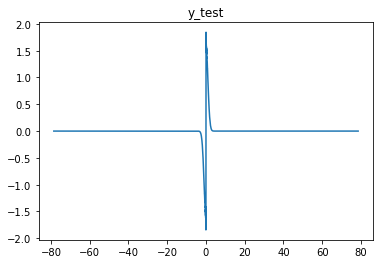

2.2475514508969026


In [225]:
# implement experiment 2

N_train = 2 ** 12
N_test = 2 ** 14

seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

x_train, y_train, x_validation, y_validation, x_test, y_test = generate_data(N_train, N_test)

# Save training values for training error evaluation
x_train_eval = x_train
y_train_eval = y_train

# Normalize the training data
x_mean = x_train.mean(axis=0)
x_std = x_train.std(axis=0)
y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis=0)
x_train = (x_train - x_mean) / x_std
y_train = (y_train - y_mean) / y_std

# px = stats.norm.pdf(x_test, loc=0, scale=1) # write the  function 
px = 1 / x_std / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * (((x_test) / x_std) ** 2))
px_train = 1 / x_std / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * ((x_train / x_std) ** 2))
px_validation = 1 / x_std / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * ((x_validation / x_std) ** 2))

d = 1

w0 = Method_2_w0(x_train, y_train, 1, 2,  px_train)
print(w0)

snc = np.ones((len(x_validation[:, 0]), len(x_validation[:, 0])))
snc_training = np.ones((len(x_train[:, 0]), len(x_train[:, 0])))

for i in range(d):
    diff = x_validation[:, i:i + 1] - x_validation[:, i:i + 1].T
    snc *= np.sinc(w0 * diff / np.pi)
    diff_training = x_train[:, i:i + 1] - x_train[:, i:i + 1].T
    snc_training *= np.sinc(w0 * diff_training / np.pi)

In [226]:
batch_size = 32
epochs = 1000
num_evals=100
mod = int(epochs / num_evals)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1).batch(batch_size)

loss_fn=tf.keras.losses.mean_squared_error
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

def nn_predict(x):
    x = (x - x_mean) / x_std
    beta = model(x) * y_std + y_mean
    return beta.numpy()
    
FVU = []
FVU_validation = []
SB_M1 = []

# Training step
for epoch in range(epochs):

    # Train the Network
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # Record the loss computations
        with tf.GradientTape() as tape:
            pred = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, pred)
        # Compute and apply gradients
        model.grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(model.grads, model.trainable_weights))

    # Print the training loss for every tenth epoch
    if epoch % 10 == 0:
        print("\nEnd of epoch  " + str(epoch) + ", Training error " +
                      str(np.mean((y_train_eval - nn_predict(x_train_eval)) ** 2))) 
                      
    pred = nn_predict(x_train_eval)
    pred_validation = nn_predict(x_validation)
    FVU = np.append(FVU, FVU_compute(y_train, pred))
    FVU_validation = np.append(FVU_validation, FVU_compute(y_validation, pred_validation))
    
    w0= Method_2_w0(x_train, y_train, 1, 2, px_train)
    pred_validation = nn_predict(x_validation)
    E_low, E_high, SB_ = Method_2(w0, x_validation, y_validation, pred_validation, px_validation, snc)
    SB_M1 = np.append(SB_M1, SB_)
    
t_vec = np.arange(0, epochs)
plt.plot(t_vec[1:], FVU_validation[1:])
plt.show()

plt.plot(t_vec[1:], SB_M1[1:], color='0.5', label="Method 1")
plt.show()


End of epoch  0, Training error nan


KeyboardInterrupt: 

In [ ]:
class Compute_SB_Callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        

        # predicting the data
        x_tr_norm = (x_train - x_mean)/x_std
        pred = model.predict(x_tr_norm)
        pred = pred * y_std + y_mean
        pred = np.reshape(pred, (N_train, 1))
        
        x_vali_norm = (x_validation - x_mean)/x_std
        pred_validation = model.predict(x_vali_norm)
        pred_validation = pred_validation * y_std + y_mean
        pred_validation = np.reshape(pred_validation, (N_train, 1))

        FVU_vali = FVU_compute(y_validation, pred_validation)
        E_low, E_high, SB = Method_2(w0, x_validation, y_validation, pred_validation, px_validation, snc)
        print(SB)
        
        i = int(epoch - 1)
        FVU_vali_list[i] = FVU_vali
        SB_list[i] = SB[0,0]
        
        #print(SB)

In [ ]:
# compling the model 
adam = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer = 'adam', loss = 'mse')

N_epoch = 1000
FVU_vali_list = np.zeros(N_epoch)
SB_list = np.zeros(N_epoch)

SB_callback = Compute_SB_Callback()
tf.random.set_seed(seed)
beta = model.fit(x_train, y_train, epochs=N_epoch, batch_size=32, callbacks=[SB_callback])

my_loss = beta.history['loss']

Epoch 1/1000
128/128 [==============================] - 1s 2ms/step - loss: nan
Epoch 2/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 3/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 4/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 5/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 6/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 7/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 8/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 9/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 10/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 11/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 12/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 13/1000
128/128 [==============

Exception ignored in: <function ScopedTFGraph.__del__ at 0x000002AEFF18C1F0>
Traceback (most recent call last):
  File "d:\Anaconda\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 54, in __del__
    self.deleter(self.graph)
AttributeError: deleter


[[nan]]
128/128 [==============================] - 1s 5ms/step - loss: nan
Epoch 101/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 102/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 103/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 104/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 105/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 106/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 107/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 108/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 109/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 110/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 111/1000
128/128 [==============================] - 0s 2ms/step - loss: nan
Epoch 112/1000
128/128 

KeyboardInterrupt: 

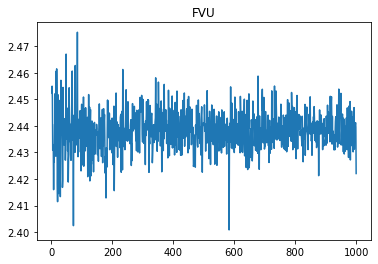

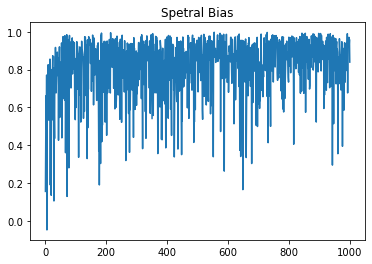

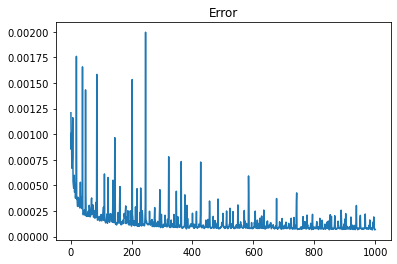

In [ ]:
epoch_list = np.arange(1, N_epoch+1)

plt.plot(epoch_list, FVU_vali_list)
#plt.ylim(0,1)
plt.title('FVU')
plt.show()

plt.plot(epoch_list, SB_list)
plt.title('Spetral Bias')
plt.show()

plt.plot(epoch_list, my_loss)
plt.title('Error')
#plt.ylim(0,0.05)
plt.show()